(bass_example)=
# Introduction to the Bass Diffusion Model

## What is the Bass Model?

The Bass diffusion model, developed by Frank Bass in 1969, is a mathematical model that describes how new products get adopted in a population over time. It's widely used in marketing to forecast sales of new products, especially when historical data is limited or non-existent.

The model captures the entire lifecycle of product adoption, from introduction to saturation, making it a powerful tool for product planning and marketing strategy development.

## The Motivation Behind the Bass Model

Before the Bass model, companies struggled to predict the adoption patterns of new products. Traditional forecasting methods often failed because they couldn't account for the social dynamics that drive product adoption. Frank Bass recognized that product adoption follows a distinct pattern:

- **Initial slow growth**: When a product first launches, adoption starts slowly
- **Rapid acceleration**: As more people adopt, word-of-mouth spreads and adoption accelerates
- **Eventual saturation**: Eventually, the market becomes saturated and adoption slows down

The Bass model provides a mathematical framework to capture these patterns, enabling businesses to make more informed decisions about production planning, inventory management, and marketing resource allocation.

## Mathematical Formulation

The Bass model is based on a differential equation that describes the rate of adoption:

$$\frac{f(t)}{1-F(t)} = p + q F(t)$$

Where:

- $F(t)$ is the installed base fraction (cumulative proportion of adopters)
- $f(t)$ is the rate of change of the installed base fraction ($f(t) = F'(t)$)
- $p$ is the coefficient of innovation or external influence
- $q$ is the coefficient of imitation or internal influence

The solution to this equation gives the adoption curve:

$$F(t) = \frac{1 - e^{-(p+q)t}}{1 + (\frac{q}{p})e^{-(p+q)t}}$$

The adoption rate at time $t$ is given by:

$$f(t) = (p + q F(t))(1 - F(t))$$

Alternatively, this can be written as:

$$f(t) = \frac{(p+q)^2 \cdot e^{-(p+q)t}}{p \cdot (1+\frac{q}{p}e^{-(p+q)t})^2}$$

To calculate the expected number of adoptions at each time point, we multiply $f(t)$ by the market potential ($m$):

$$\text{adoptions}(t) = m \cdot f(t)$$

## Understanding the Key Parameters

The model has three main parameters:

- **Market potential (m)**: Total number of eventual adopters (the ultimate market size)
- **Innovation coefficient (p)**: Measures external influence like advertising and media - typically 0.01-0.03
- **Imitation coefficient (q)**: Measures internal influence like word-of-mouth - typically 0.3-0.5

### Parameter Interpretation

- A higher **p** value indicates stronger external influence (advertising, marketing)
- A higher **q** value indicates stronger internal influence (word-of-mouth, social interactions)
- The ratio **q/p** indicates the relative strength of internal vs. external influences
- The peak of adoption occurs at time 

$$t^* = \frac{\ln(q/p)}{p+q}$$

### Innovators vs. Imitators

The Bass model distinguishes between two types of adopters:

1. **Innovators**: People who adopt independently of others' decisions, influenced mainly by mass media and external communications
   - Mathematically represented as: $\text{innovators}(t) = m \cdot p \cdot (1 - F(p, q, t))$

2. **Imitators**: People who adopt because of social influence and word-of-mouth from previous adopters
   - Mathematically represented as: $\text{imitators}(t) = m \cdot q \cdot F(p, q, t) \cdot (1 - F(p, q, t))$

## Real-World Applications

The Bass model has been successfully applied to forecast the adoption of various products and technologies:

- **Consumer durables**: TVs, refrigerators, washing machines
- **Technology products**: Smartphones, computers, software
- **Pharmaceutical products**: New drugs and treatments
- **Entertainment products**: Movies, games, streaming services
- **Services and subscriptions**: Banking services, subscription plans

## Business Value: Why the Bass Model Matters to Executives and Marketers

From a business perspective, the Bass diffusion model provides substantial competitive advantages and ROI benefits:

### 1. Resource Optimization and Cash Flow Management

- **Production Planning**: Avoid costly overproduction or stockouts by accurately forecasting demand curves
- **Marketing Budget Allocation**: Optimize spending across the product lifecycle, investing more during key inflection points
- **Supply Chain Efficiency**: Coordinate with suppliers and distributors based on predicted adoption rates
- **Cash Flow Optimization**: Better predict revenue streams, improving financial planning and investor relations

### 2. Strategic Decision Making

- **Launch Timing**: Determine the optimal time to enter a market based on diffusion patterns
- **Pricing Strategy**: Implement dynamic pricing strategies aligned with the adoption curve
- **Competitive Analysis**: Compare your product's adoption parameters with competitors to identify strengths and weaknesses
- **Product Portfolio Management**: Make informed decisions about when to phase out older products and introduce new ones

### 3. Risk Mitigation

- **Scenario Planning**: Test different market assumptions and external factors through parameter variations
- **Early Warning System**: Identify deviations from expected adoption curves early, enabling faster intervention
- **Investment Justification**: Provide data-driven forecasts to justify R&D and marketing investments to stakeholders

### 4. Performance Measurement

- **Marketing Effectiveness**: Measure the impact of marketing campaigns on the innovation coefficient (p)
- **Word-of-Mouth Strength**: Quantify the power of your brand's social influence through the imitation coefficient (q)
- **Total Market Potential**: Validate or adjust your total addressable market estimates (m)

In today's data-driven business environment, companies that effectively utilize models like Bass diffusion gain a significant competitive edge through more precise forecasting, better resource allocation, and strategic market timing.

## Bayesian Extensions

In this notebook, we whow how to generate simulated data from the Bass model and fit a Bayesian model to it. The Bayesian formulation  offers several advantages:

- **Uncertainty quantification** through prior distributions on parameters
- **Hierarchical modeling** for multiple products or markets
- **Incorporation of expert knowledge** through informative priors
- **Full probability distributions** for future adoption forecasts

## What we'll do in this notebook

In this notebook, we'll:
1. Set up parameters for a Bass model simulation
2. Generate simulated adoption data for multiple products
3. Visualize the adoption curves
4. Fit the Bass model to our simulated data using PyMC
5. Interpret the results

## Prepare Notebook

In [ ]:
from typing import Any

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import pandas as pd
import pymc as pm

from pymc_marketing.bass.model import create_bass_model
from pymc_marketing.plot import plot_curve
from pymc_marketing.prior import Prior, Scaled

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [ ]:
seed: int = sum(map(ord, "bass"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

## Setting Up Simulation Parameters

First, we'll set up the parameters for our simulation. This includes:

- The time period for our simulation (in weeks)
- The number of products to simulate
- Start dates for the simulation period
- Random start dates for each product (since not all products launch at the same time)

In [ ]:
def setup_simulation_parameters(
    n_weeks: int = 52,
    n_products: int = 9,
    start_date: str = "2023-01-01",
    cutoff_start_date: str = "2023-12-01",
) -> tuple[
    npt.NDArray[np.int_],
    pd.DatetimeIndex,
    pd.DatetimeIndex,
    list[str],
    pd.Series,
    dict[str, Any],
]:
    """Set up initial parameters for the Bass diffusion model simulation.

    Parameters
    ----------
    n_weeks : int
        Number of weeks to simulate
    n_products : int
        Number of products to include in the simulation
    start_date : str
        Starting date for the simulation period
    cutoff_start_date : str
        Latest possible start date for products

    Returns
    -------
    T : numpy.ndarray
        Time array (weeks)
    possible_dates : pandas.DatetimeIndex
        All dates in the simulation period
    possible_start_dates : pandas.DatetimeIndex
        Possible start dates for products
    products : list
        List of product names
    product_start : pandas.Series
        Start date for each product
    coords : dict
        Coordinates for PyMC model
    """
    # Set a seed for reproducibility
    seed = sum(map(ord, "Bass Model"))
    rng = np.random.default_rng(seed)

    # Create time array and date range
    T = np.arange(n_weeks)
    possible_dates = pd.date_range(start_date, freq="W-MON", periods=n_weeks)
    cutoff_start_date = pd.to_datetime(cutoff_start_date)
    cutoff_start_date = cutoff_start_date + pd.DateOffset(weeks=1)
    possible_start_dates = possible_dates[possible_dates < cutoff_start_date]

    # Generate product names and random start dates
    products = [f"P{i}" for i in range(n_products)]
    product_start = pd.Series(
        rng.choice(possible_start_dates, size=len(products)),
        index=pd.Index(products, name="product"),
    )

    coords = {"T": T, "product": products}
    return T, possible_dates, possible_start_dates, products, product_start, coords

## Creating Prior Distributions

For our Bayesian Bass model, we need to specify prior distributions for the key parameters:

- **m (market potential)**: How many units can potentially be sold in total
- **p (innovation coefficient)**: Rate of adoption from external influences
- **q (imitation coefficient)**: Rate of adoption from internal/social influences
- **likelihood**: The probability distribution that models the observed adoption data

In [ ]:
def create_bass_priors() -> dict[str, Prior | Scaled]:
    """Define prior distributions for the Bass model parameters.

    Returns
    -------
    dict
        Dictionary of prior distributions for m, p, q, and likelihood

    Notes
    -----
    - m: Market potential (scaled Gamma distribution)
    - p: Innovation coefficient (Beta distribution)
    - q: Imitation coefficient (Beta distribution)
    - likelihood: Observation model (Negative Binomial)
    """
    return {
        # We use a scaled Gamma distribution for the market potential.
        "m": Scaled(Prior("Gamma", mu=1, sigma=0.001, dims="product"), factor=50_000),
        "p": Prior("Beta", mu=0.38, sigma=0.05, dims="product"),
        "q": Prior("Beta", mu=0.35, sigma=0.3, dims="product"),
        "likelihood": Prior("NegativeBinomial", n=1.5, dims="product"),
    }

## Generate Synthetic Data

1. Set up the simulation parameters
2. Create the Bass model with our specified priors
3. Generate simulated adoption data
4. Transform the data to use actual calendar dates

In [ ]:
def sample_bass_data(model):
    """Generate a sample from the prior predictive distribution of the Bass model.

    Parameters
    ----------
    model : pymc.Model
        The PyMC model to sample from

    Returns
    -------
    xarray.DataArray
        Simulated adoption data
    """
    with model:
        idata = pm.sample_prior_predictive(random_seed=rng)
    return idata.prior.y.sel(chain=0, draw=0)


def transform_to_actual_dates(bass_data, product_start, possible_dates):
    """Transform simulation data from time index to calendar dates.

    Parameters
    ----------
    bass_data : xarray.DataArray
        Simulated bass model data
    product_start : pandas.Series
        Start date for each product
    possible_dates : pandas.DatetimeIndex
        All dates in the simulation period

    Returns
    -------
    pandas.DataFrame
        Adoption data with actual calendar dates
    """
    bass_data = bass_data.to_dataset()
    bass_data["product_start"] = product_start.to_xarray()

    df_bass_data = (
        bass_data.to_dataframe().drop(columns=["chain", "draw"]).reset_index()
    )
    df_bass_data["actual_date"] = df_bass_data["product_start"] + pd.to_timedelta(
        7 * df_bass_data["T"], unit="days"
    )

    return (
        df_bass_data.set_index(["actual_date", "product"])
        .y.unstack(fill_value=0)
        .reindex(possible_dates, fill_value=0)
    )

In [ ]:
# Setup simulation parameters
T, possible_dates, _, products, product_start, coords = setup_simulation_parameters()

# Create and configure the Bass model
priors = create_bass_priors()
generative_model = create_bass_model(t=T, coords=coords, observed=None, priors=priors)

# Sample and visualize results
bass_data = sample_bass_data(generative_model)
actual_data = transform_to_actual_dates(bass_data, product_start, possible_dates)

Sampling: [m_unscaled, p, q, y]


## Visualizing the Simulation Results

In [ ]:
actual_data

product,P0,P1,P2,P3,P4,P5,P6,P7,P8
2023-01-02,0,0,0,0,0,0,0,0,0
2023-01-09,0,0,0,0,0,0,0,0,0
2023-01-16,0,0,0,10577,14922,0,0,0,0
2023-01-23,0,0,0,5592,9836,0,0,0,0
2023-01-30,0,0,3485,4742,6380,0,0,0,0
2023-02-06,0,0,265,3407,13611,0,0,0,0
2023-02-13,0,0,4494,536,5365,0,0,0,0
2023-02-20,0,0,4109,15,1194,0,0,0,0
2023-02-27,0,0,76,635,1811,0,0,0,0
2023-03-06,0,0,1132,166,1041,0,0,0,10550


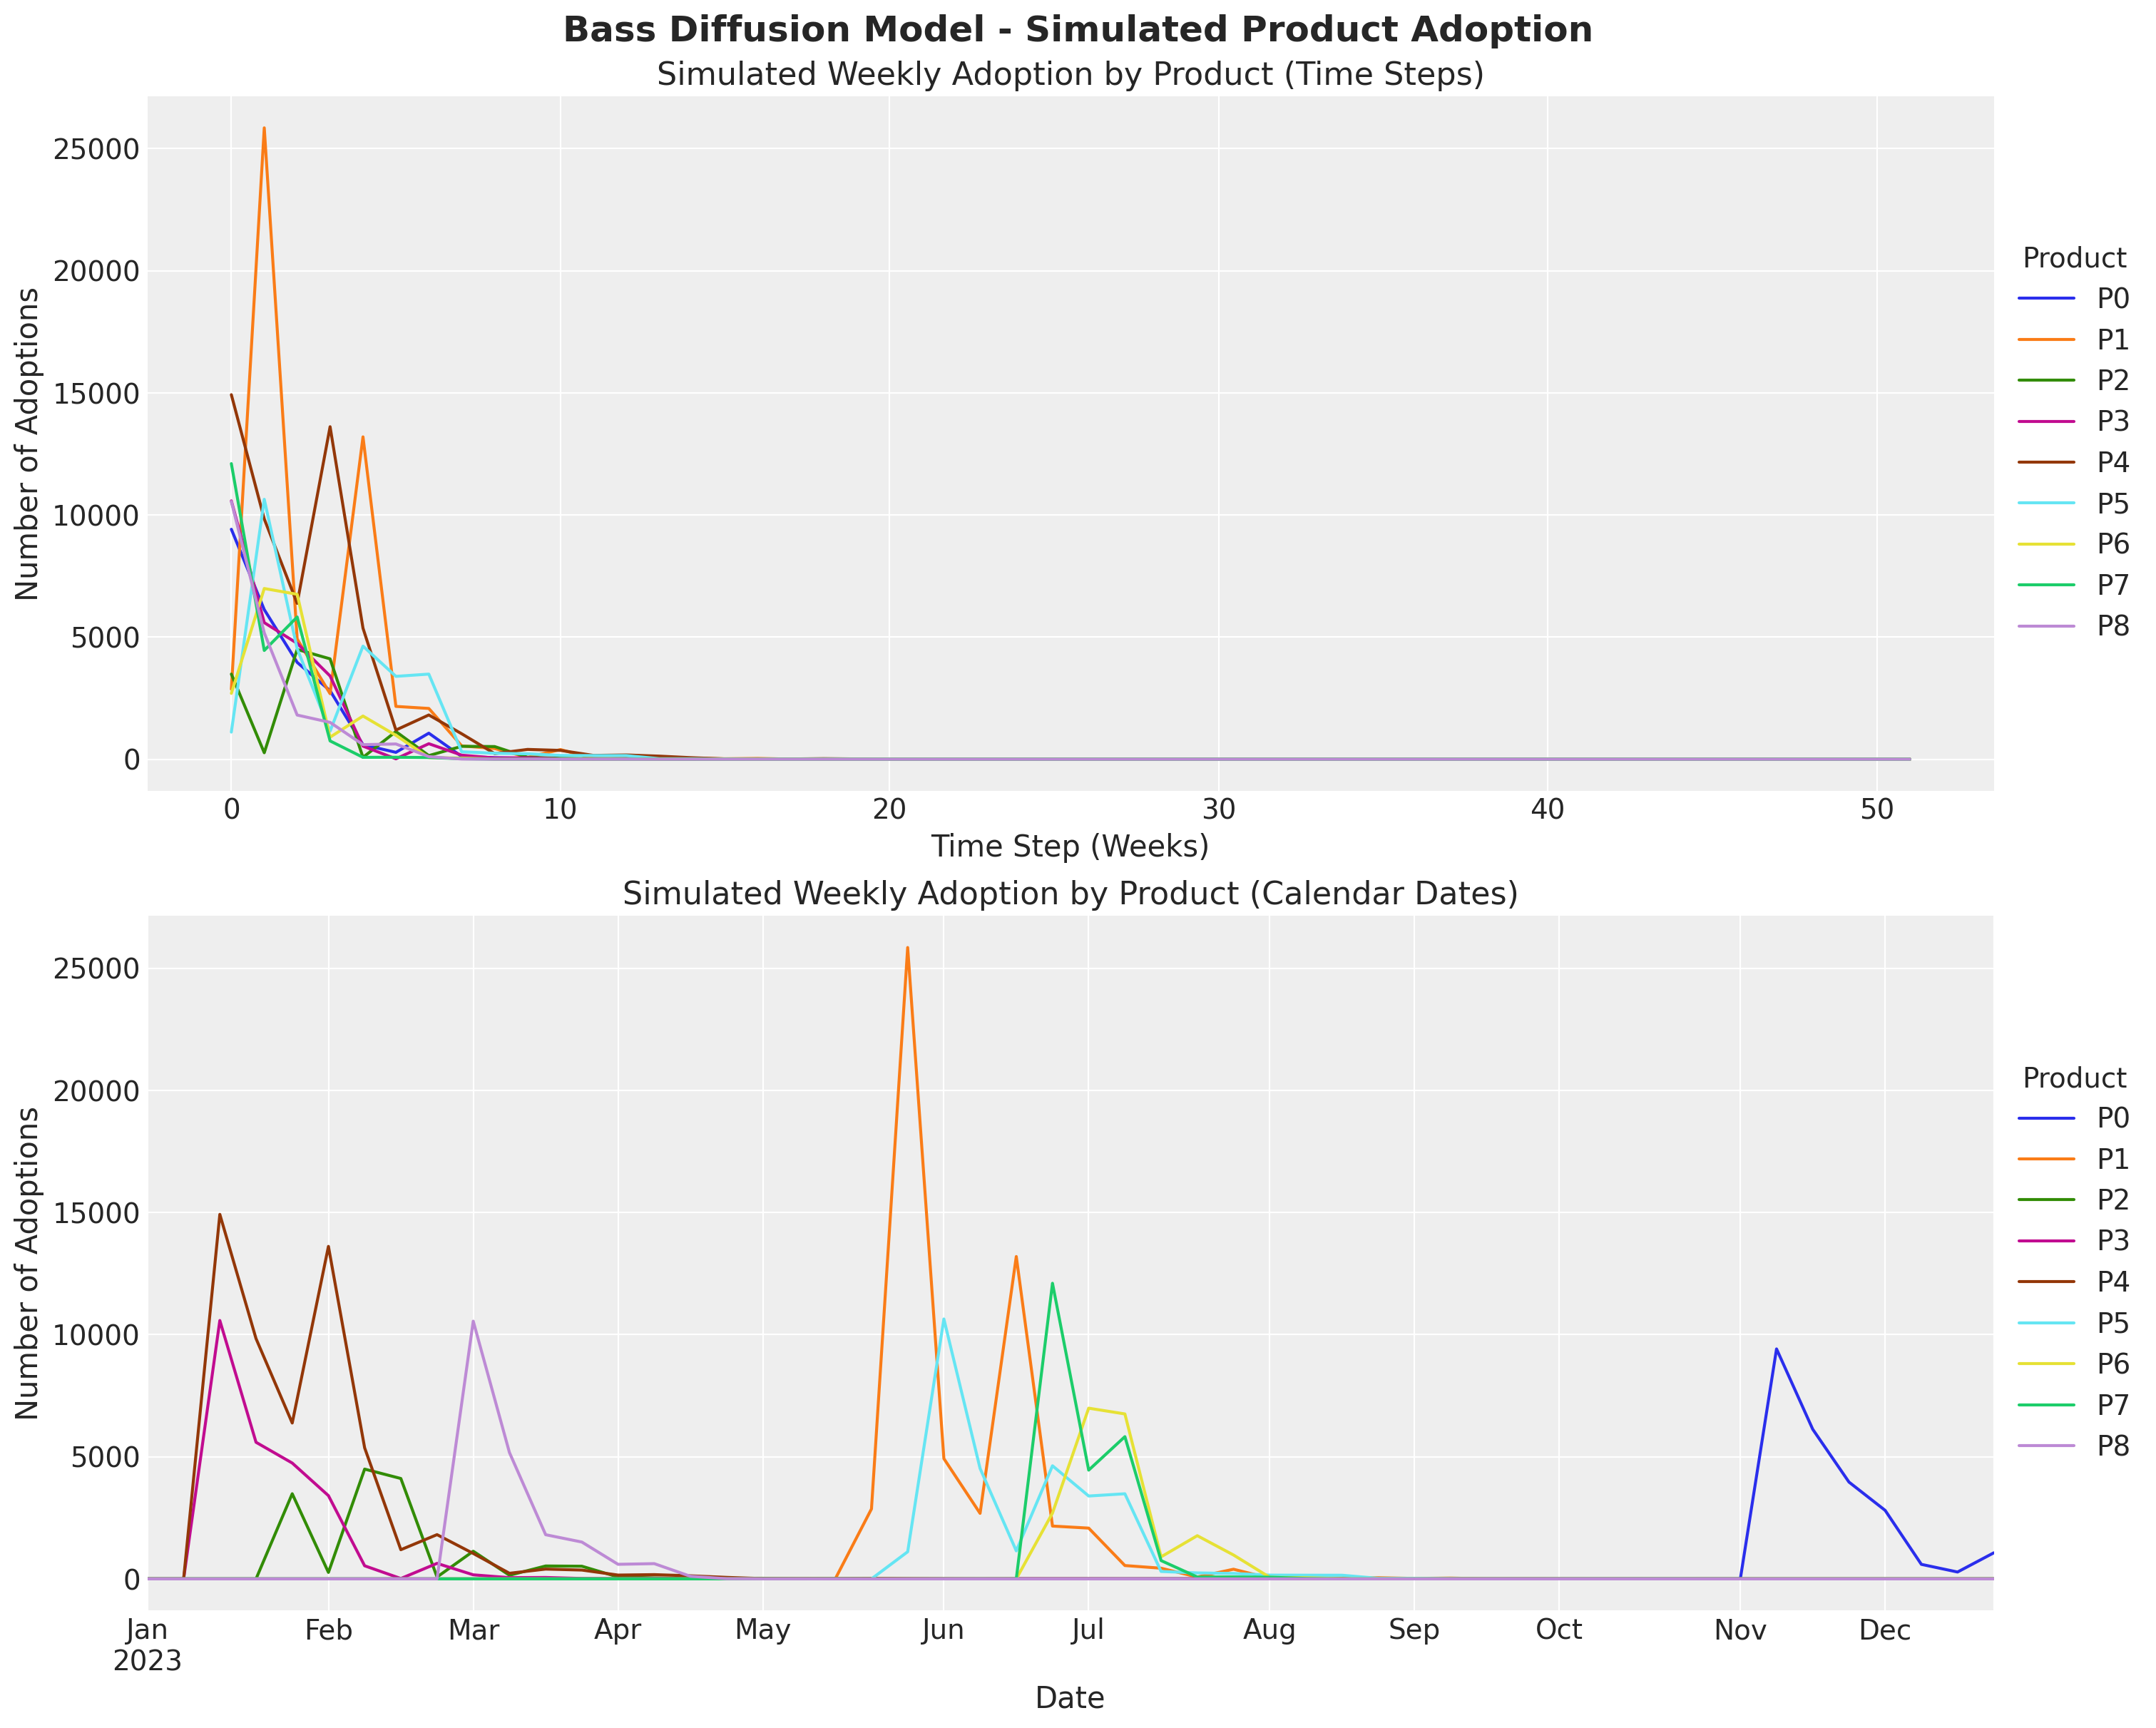

In [ ]:
fig, ax = plt.subplots(
    nrows=2, ncols=1, figsize=(15, 12), sharex=False, sharey=True, layout="constrained"
)

# Plot raw simulated data (by time step)
bass_data.to_series().unstack().plot(ax=ax[0])
ax[0].legend(
    title="Product", title_fontsize=14, loc="center left", bbox_to_anchor=(1, 0.5)
)
ax[0].set(
    title="Simulated Weekly Adoption by Product (Time Steps)",
    xlabel="Time Step (Weeks)",
    ylabel="Number of Adoptions",
)

# Plot data with actual calendar dates
actual_data.plot(ax=ax[1])
ax[1].legend(
    title="Product", title_fontsize=14, loc="center left", bbox_to_anchor=(1, 0.5)
)
ax[1].set(
    title="Simulated Weekly Adoption by Product (Calendar Dates)",
    xlabel="Date",
    ylabel="Number of Adoptions",
)

fig.suptitle(
    "Bass Diffusion Model - Simulated Product Adoption", fontsize=18, fontweight="bold"
);

## Fit the Model


In [ ]:
with pm.observe(generative_model, {"y": bass_data.values}) as model:
    idata = pm.sample(
        tune=1_500,
        draws=2_000,
        chains=4,
        target_accept=0.9,
        nuts_sampler="nutpie",
        compile_kwargs={"mode": "NUMBA"},
        random_seed=rng,
    )

    idata.extend(
        pm.sample_posterior_predictive(
            idata, model=model, extend_inferencedata=True, random_seed=rng
        )
    )

Progress,Draws,Divergences,Step Size,Gradients/Draw
,3500,1,0.22,31
,3500,0,0.27,15
,3500,0,0.26,31
,3500,0,0.25,31


Sampling: [y]


Output()

## Examining Posterior Predictions for Specific Products

Let's look at the posterior predictive distributions  to see how well our model captures the simulated data.

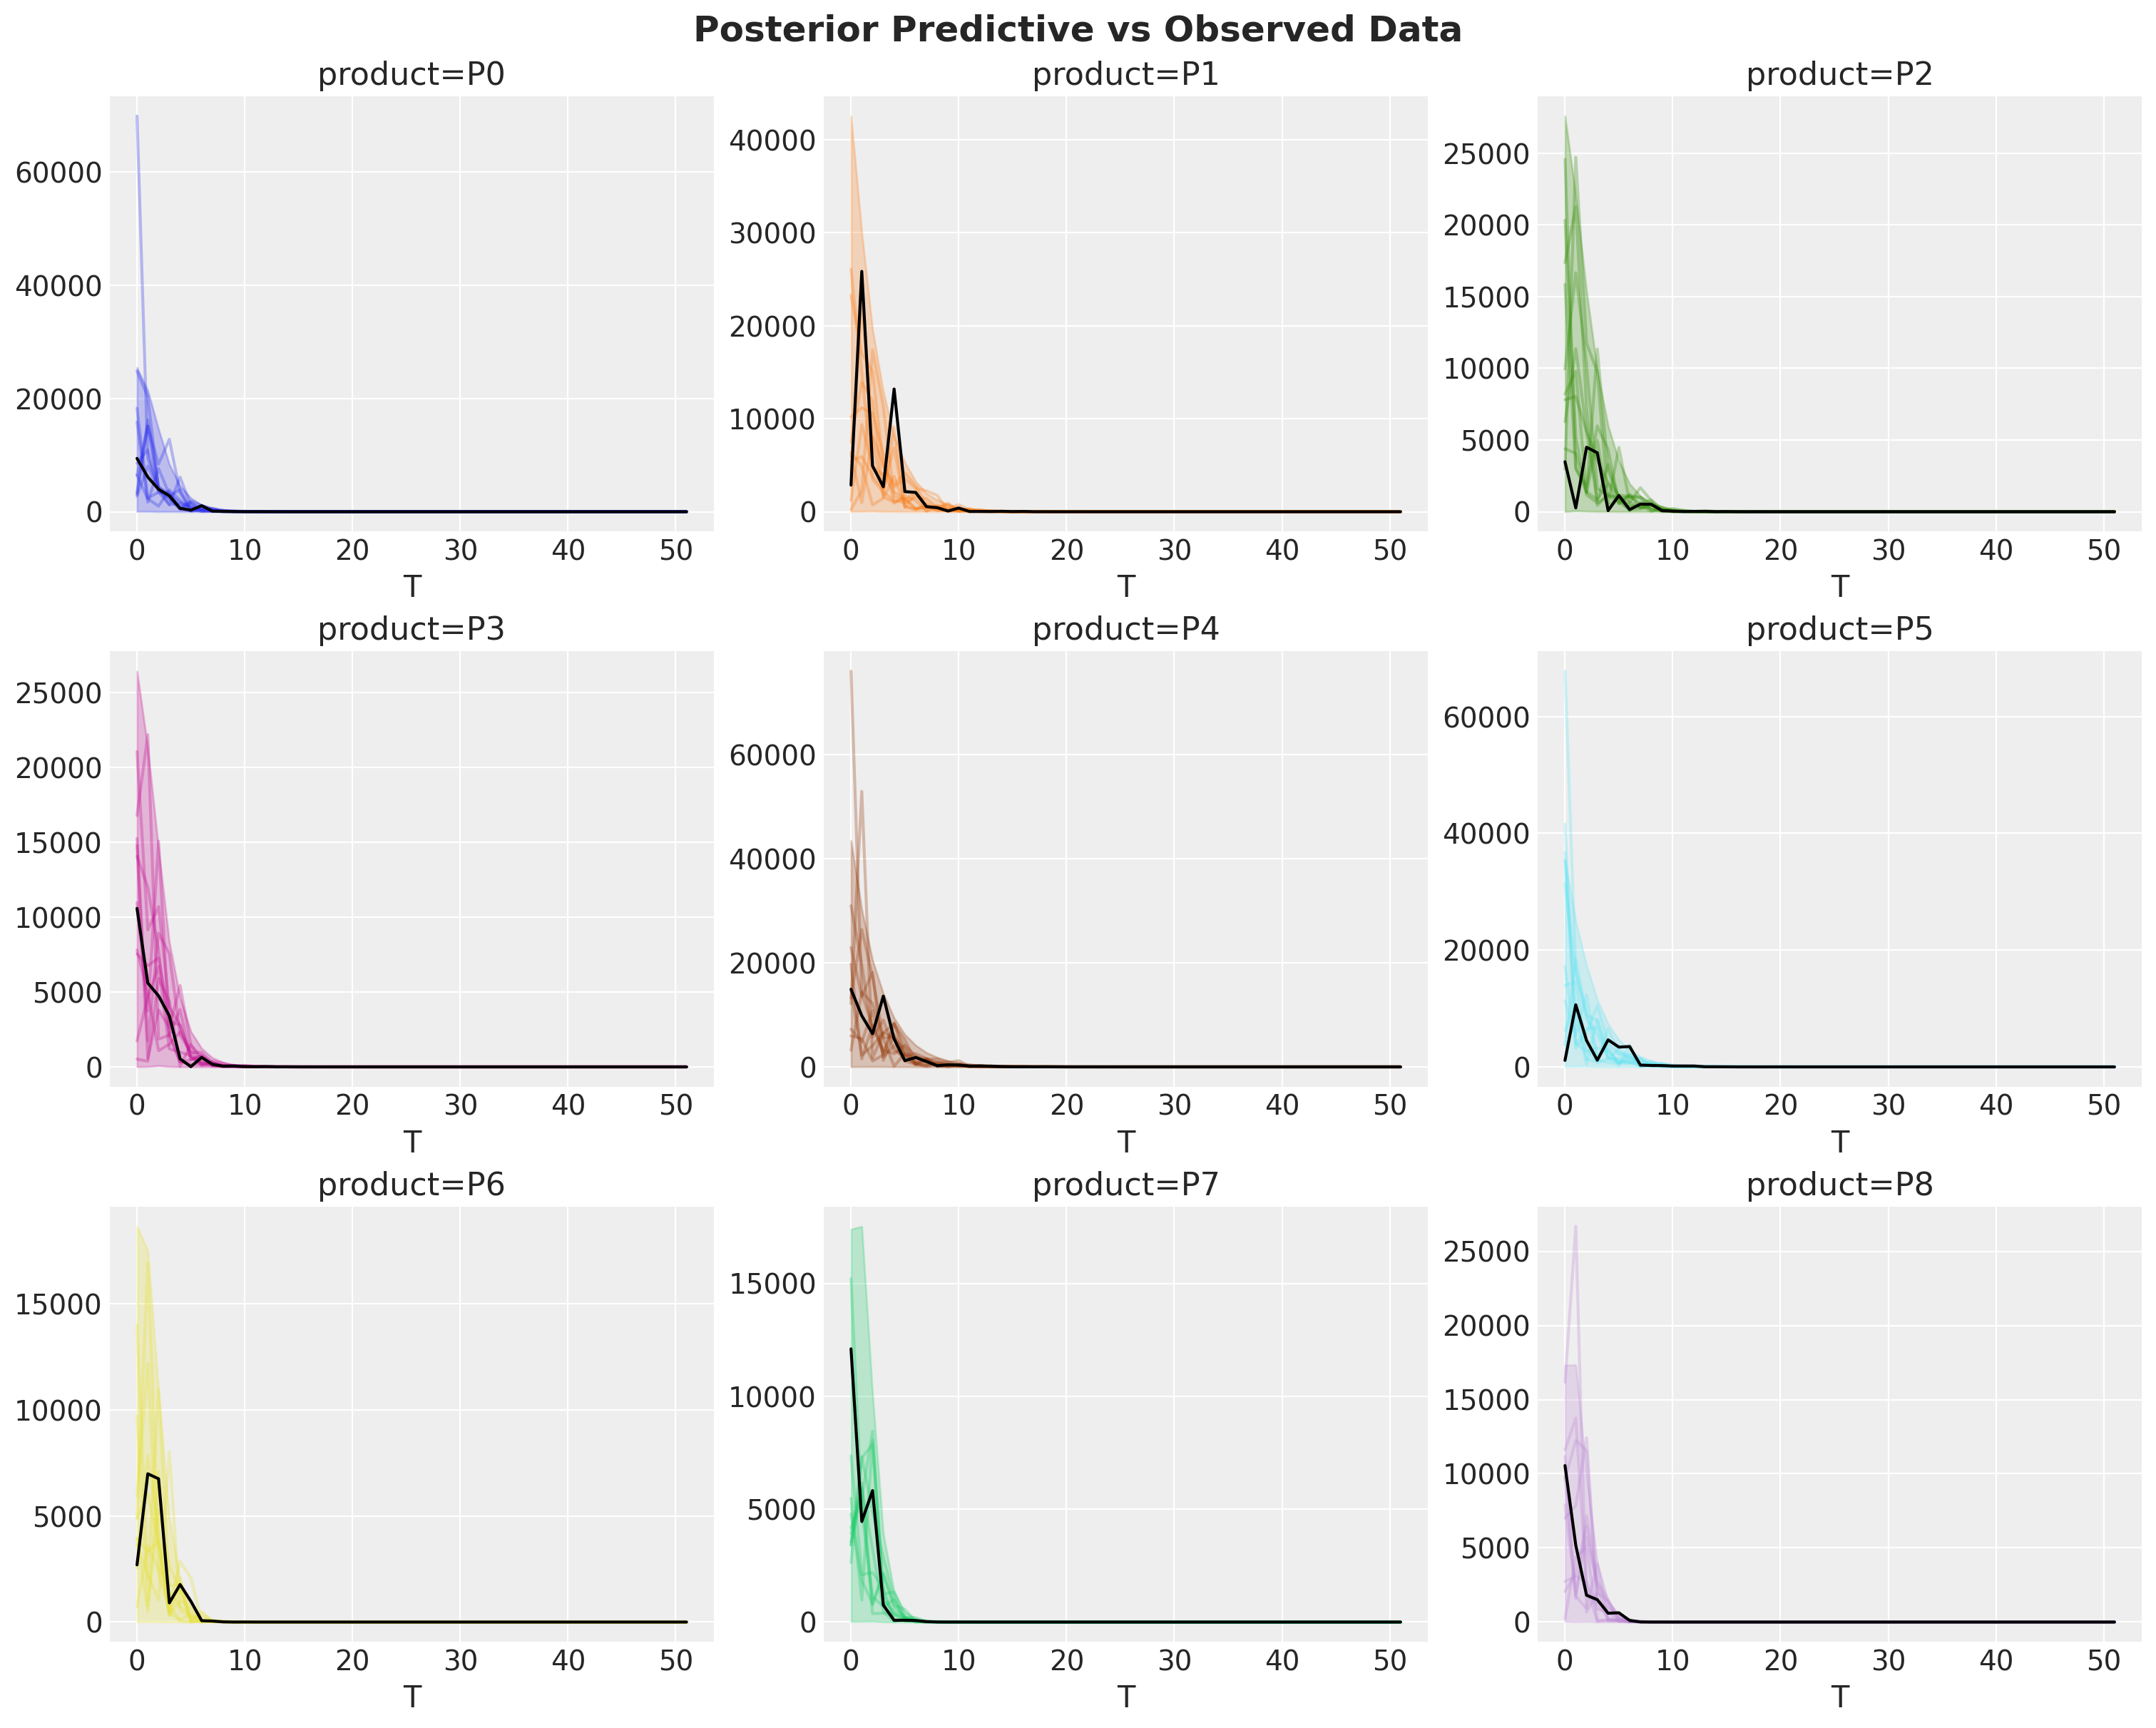

In [ ]:
fig, axes = plt.subplots(
    nrows=3, ncols=3, figsize=(15, 12), sharex=False, sharey=False, layout="constrained"
)

idata["posterior_predictive"]["y"].pipe(plot_curve, {"T"}, axes=axes)

for i, ax in enumerate(axes.flatten()):
    ax.plot(T, bass_data[:, i], color="black")

fig.suptitle("Posterior Predictive vs Observed Data", fontsize=18, fontweight="bold");

In [ ]:
%load_ext watermark
%watermark -n -u -v -iv -w -p nutpie,pymc_marketing,pytensor

Last updated: Wed Apr 23 2025

Python implementation: CPython
Python version       : 3.12.9
IPython version      : 9.0.2

nutpie        : 0.14.3
pymc_marketing: 0.13.1
pytensor      : 2.30.3

numpy         : 2.1.3
matplotlib    : 3.10.1
pymc_marketing: 0.13.1
arviz         : 0.21.0
pymc          : 5.22.0
pandas        : 2.2.3

Watermark: 2.5.0

